In [1]:
# default_exp objects

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *
from rtma.sine_model import *

# Objects

## Signal

In [5]:
#export
class Signal:
    def __init__(self, filename: str) -> None:
        self.filename = filename        
        self.x, self.sample_rate = load_audio(filename)
    
    @property
    def n_samples(self) -> int:
        return self.x.shape[-1]
    
    @property
    def duration(self) -> float:
        return self.n_samples / self.sample_rate
        
    def __len__(self) -> int:
        return self.n_samples
    
    def play(self) -> None:
        play_audio(self.x, self.sample_rate)
        
    def plot(self, *args, **kwargs) -> None:
        return plot(self.x, *args, **kwargs)
        
    def __str__(self) -> str:
        return f'Signal("{self.filename}")'
    
    def __repr__(self) -> str:
        return str(self)

In [6]:
fn = "data/E_octaves_both.wav"
#fn = "../../sms-tools/sounds/flute-A4.wav"

s = Signal(fn)
s

Signal("data/E_octaves_both.wav")

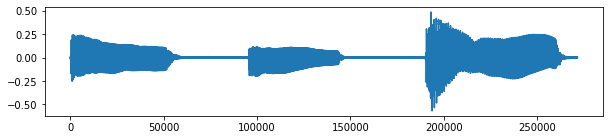

In [7]:
s.play()
s.plot()

In [8]:
s.duration, s.n_samples, len(s)

(5.6567083333333334, 271522, 271522)

## Base Analysis

In [9]:
#export
class Frame:
    def __init__(self, x: np.ndarray, index: int):
        self.x = x
        self.index = index
    
    def plot(self):
        plot(self.x)

In [10]:
#export
class Analysis:
    def __init__(self, 
                 signal: Signal,
                 frame_size: int, 
                 hop_size: int) -> None:
        self.signal = signal
        self.frame_size = frame_size
        self.hop_size = hop_size
    
    def __repr__(self) -> str:
        return f'Analysis({self.signal}, frame_size={self.frame_size}, hop_size={self.hop_size})'
    
    @property
    def overlap(self) -> int:
        return self.frame_size - self.hop_size
    
    @property
    def frames(self):
        x_pad = np.pad(self.signal.x, (self.overlap, 0), mode='constant')
        offset = 0
        frame_i = 0
        while offset < x_pad.size:
            x_frame = x_pad[offset:offset+self.frame_size]
            if x_frame.size < self.frame_size:
                x_frame = np.pad(x_frame, (0, self.frame_size-x_frame.size), mode='constant')
            yield Frame(x_frame, frame_i)
            offset += self.hop_size
            frame_i += 1
    
    @property
    def sample_rate(self):
        return self.signal.sample_rate

(1814,
 Analysis(Signal("data/E_octaves_both.wav"), frame_size=601, hop_size=150))

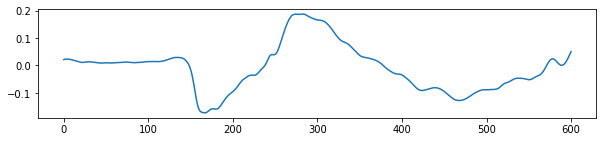

In [11]:
a = Analysis(s, frame_size=601, hop_size=150)
frames = list(a.frames)
frames[5].plot()
len(frames), a

## Spectral Analysis

In [12]:
#export
class SpectralFrame(Frame):
    def __init__(self, frame: Frame, window: np.ndarray, fft_size: int):
        assert frame.x.size == window.size
        assert frame.x.size <= fft_size
        assert is_power_of_two(fft_size)
        super().__init__(frame.x * window, frame.index)
        
        # instance variables
        self.frame = frame
        self.window = window
        self.fft_size = fft_size
        
        # lazy computed properties
        self._fft_buffer = None
        self._dft = None
        self._magnitudes = None
        self._phases = None
    
    @property
    def fft_buffer(self):
        if self._fft_buffer is None:
            self._fft_buffer = zero_phase_buffer(self.x, n_fft=self.fft_size)
        return self._fft_buffer
    
    @property
    def dft(self):
        if self._dft is None:
            self._dft = np.fft.rfft(self.fft_buffer)
        return self._dft
    
    @property
    def magnitudes(self):
        if self._magnitudes is None:
            self._magnitudes = amplitude_to_decibels(abs(self.dft))
        return self._magnitudes
    
    @property
    def phases(self):
        if self._phases is None:
            dft = self.dft.copy()
            dft.real[abs(dft.real) < EPSILON] = 0.0
            dft.imag[abs(dft.imag) < EPSILON] = 0.0
            self._phases = np.unwrap(np.angle(dft))
        return self._phases
    
    def plot_magnitudes(self):
        return plot(self.magnitudes)
    
    def plot_phases(self):
        return plot(self.phases)

In [13]:
#export
class SpectralAnalysis(Analysis):
    def __init__(self,
                 *args,
                 fft_size: int,
                 window_name: str,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.fft_size = fft_size
        self.window_name = window_name
        window = get_cola_window(window_name, self.frame_size, self.hop_size)
        self.window = window / window.sum()
        self._magnitudes = None
    
    @property
    def spectral_frames(self):
        for frame in super().frames:
            yield SpectralFrame(frame, self.window, self.fft_size)
    
    @property
    def magnitudes(self):
        if self._magnitudes is None:
            self._magnitudes = np.stack([f.magnitudes for f in self.spectral_frames])
        return self._magnitudes
        
    def plot_magnitudes(self, max_plot_freq: float, figsize=(12, 6)):
        n_bins = int(self.fft_size * max_plot_freq / self.sample_rate) + 1
        n_frames = self.magnitudes.shape[0]
        
        frame_times = np.arange(n_frames) / self.sample_rate * self.hop_size
        bin_freqs = np.arange(n_bins) * self.sample_rate / self.fft_size
        
        fig, ax = plt.subplots(1, figsize=figsize)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('frequency (Hz)')
        ax.set_xlim([0, frame_times[-1]])
        ax.set_ylim([0, bin_freqs[-1]])
        ax.pcolormesh(frame_times, bin_freqs, self.magnitudes.T[:n_bins])
        return ax

In [14]:
sa = SpectralAnalysis(s, 
                      fft_size=2048,
                      window_name='hamming',
                      frame_size=2001, 
                      hop_size=500)

In [15]:
frames = list(sa.frames)
sframes = list(sa.spectral_frames)

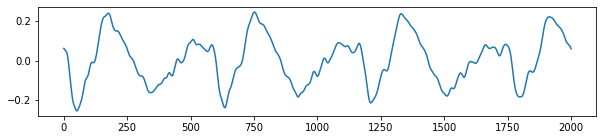

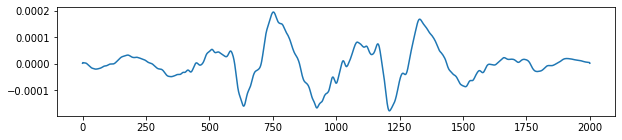

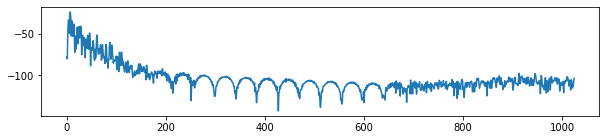

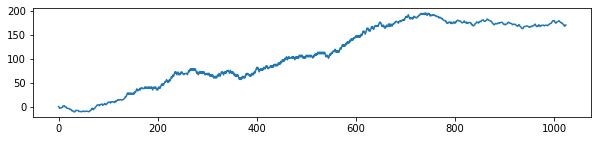

In [16]:
sf = sframes[5]
sf.frame.plot()
sf.plot()
sf.plot_magnitudes()
sf.plot_phases();

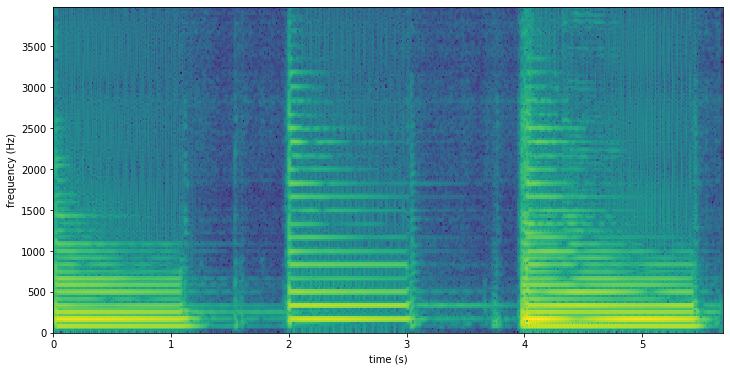

In [17]:
sa.plot_magnitudes(4000);

## Sine Model Analysis

In [18]:
#export
class Peak:
    def __init__(self, frequency: float, magnitude: float, phase: float):
        self.frequency = frequency
        self.magnitude = magnitude
        self.phase = phase
        
    def __repr__(self):
        return f'Peak(freq={self.frequency:.2f}, mag={self.magnitude:.2f},phase={self.phase:.2f})'

In [19]:
#export
class PeakFrame(SpectralFrame):
    def __init__(self, *args, peak_threshold: float, sample_rate: int, **kwargs):
        super().__init__(*args, **kwargs)
        self.peak_threshold = peak_threshold
        self.sample_rate = sample_rate
        self._peaks = None
    
    @property
    def peaks(self):
        if self._peaks is None:
            peak_i = detect_peaks(self.magnitudes, self.peak_threshold)
            ipeak_i, ipeak_m = interpolate_peaks(self.magnitudes, peak_i)
            ipeak_f = ipeak_i * self.sample_rate / self.fft_size
            ipeak_p = np.interp(ipeak_i, np.arange(self.phases.size), self.phases)
            self._peaks = [Peak(f,m,p) for f,m,p in zip(ipeak_f, ipeak_m, ipeak_p)]
        return self._peaks
    
    def plot_peaks(self):
        ax = self.plot_magnitudes()
        for p in self.peaks:
            idx = p.frequency / self.sample_rate * self.fft_size
            ax.axvline(idx, color='red')
        

In [20]:
#export
class PeakAnalysis(SpectralAnalysis):
    def __init__(self,
                 *args,
                 peak_threshold: float,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.peak_threshold = peak_threshold
    
    @property
    def peak_frames(self):
        for frame in super().frames:
            yield PeakFrame(frame,
                            window=self.window, 
                            fft_size=self.fft_size,
                            peak_threshold=self.peak_threshold,
                            sample_rate=self.sample_rate)

In [21]:
pa = PeakAnalysis(s, 
                  fft_size=2048,
                  window_name='hamming',
                  frame_size=601, 
                  hop_size=150,
                  peak_threshold=-50)

In [22]:
pframes = list(pa.peak_frames)

In [23]:
frame = pframes[5]

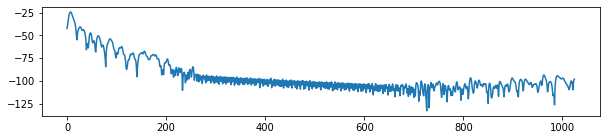

In [24]:
frame.plot_magnitudes()

In [25]:
frame.peaks[:5]

[Peak(freq=164.39, mag=-24.28,phase=-0.16),
 Peak(freq=619.78, mag=-40.58,phase=1.08),
 Peak(freq=770.99, mag=-43.80,phase=3.38),
 Peak(freq=1106.19, mag=-47.16,phase=10.37)]

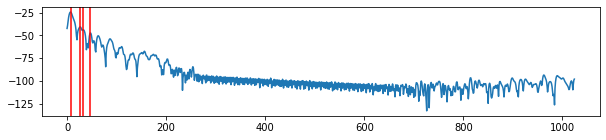

In [26]:
frame.plot_peaks()

In [27]:
[len(f.peaks) for f in pframes[:10]]

[0, 0, 1, 3, 3, 4, 6, 3, 4, 4]

### Sine Model Analysis

In [28]:
#export
class SineTrack:
    def __init__(self, peaks: List[Peak], start_index: int, end_index: Optional[int] = None):
        self.peaks = peaks
        self.start_index = start_index
        self.end_index = end_index
    
    @property
    def frequency(self):
        return self.peaks[-1].frequency
    
    @property
    def magnitude(self):
        return self.peaks[-1].magnitude
    
    def __len__(self):
        return len(self.peaks)    
    
    def __repr__(self):
        return f'SineTrack(freq={self.frequency}, start={self.start_index}, end={self.end_index}, len={len(self)})'
    
    def plot(self, ax: plt.Axes, sample_rate: int, hop_size: int):
        xs = np.arange(self.start_index, self.end_index) / sample_rate * hop_size
        ys = [peak.frequency for peak in self.peaks]
        ax.plot(xs, ys, c='k')

In [29]:
#export
class SineModelFrame:
    def __init__(self,
                 peak_frame: PeakFrame, 
                 previous_tracks: List[SineTrack],
                 freq_dev_offset: float,
                 freq_dev_slope: float):
        self.peak_frame = peak_frame
        self.previous_tracks = previous_tracks
        self.freq_dev_offset = freq_dev_offset
        self.freq_dev_slope = freq_dev_slope
        self._tracks = None
        self.track_peaks = None
    
    @property
    def index(self):
        return self.peak_frame.index
    
    @property
    def peaks(self):
        return self.peak_frame.peaks
    
    @property
    def tracks(self):
        if self._tracks is None:            
            cur_peaks = self.peaks.copy()
            cur_freqs = np.array([peak.frequency for peak in cur_peaks])
            
            prev_tracks = sorted(
                self.previous_tracks.copy(),
                key=lambda t: -t.magnitude
            )

            tracks = []
            for prev_track in prev_tracks:    
                if len(cur_peaks) > 0:
                    cur_i = np.argmin(abs(cur_freqs - prev_track.frequency))
                    freq_dev_thresh = self.freq_dev_offset + self.freq_dev_slope * cur_freqs[cur_i]
                    freq_dev = abs(cur_freqs[cur_i] - prev_track.frequency)
                    if freq_dev < freq_dev_thresh:
                        cur_freqs = np.delete(cur_freqs, cur_i)
                        track_peak = cur_peaks.pop(cur_i)
                        prev_track.peaks.append(track_peak)
                        tracks.append(prev_track)
                        continue
                prev_track.end_index = self.index
            
            for peak in cur_peaks:
                tracks.append(SineTrack([peak], self.index))
            
            self._tracks = tracks
        return self._tracks

In [30]:
#export
class SineModelAnalysis(PeakAnalysis):
    def __init__(self,
                 *args,
                 freq_dev_offset: float = 20.0,
                 freq_dev_slope: float = 0.01,
                 min_track_duration: float = 0.1,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.freq_dev_offset = freq_dev_offset
        self.freq_dev_slope = freq_dev_slope
        self.min_track_frames = round(self.sample_rate * min_track_duration / self.hop_size)
        self.all_tracks = None
        self._tracks = None
    
    @property
    def sine_model_frames(self):
        self.all_tracks = []
        tracks = []
        for peak_frame in super().peak_frames:
            frame = SineModelFrame(peak_frame, tracks, self.freq_dev_offset, self.freq_dev_slope)
            tracks = frame.tracks
            for track in tracks:
                if track.start_index == frame.index:
                    self.all_tracks.append(track)
            yield frame
    
    @property
    def tracks(self):
        if self._tracks is None:
            self.sine_model_frames
            self._tracks = [t for t in self.all_tracks.copy() if len(t) > self.min_track_frames]
        return self._tracks
    
    def plot_sines(self, max_plot_freq: float, figsize=(12, 6)):
        ax = self.plot_magnitudes(max_plot_freq=max_plot_freq, figsize=figsize)
        for track in self.tracks:
            track.plot(ax, self.sample_rate, self.hop_size)

In [31]:
sma = SineModelAnalysis(s, 
                        fft_size=2048,
                        window_name='hamming',
                        frame_size=2001,
                        hop_size=500,
                        peak_threshold=-80,
                        freq_dev_offset=5,
                        freq_dev_slope=0.01)

In [32]:
sma_frames = list(sma.sine_model_frames)
len(sma_frames)

547

In [33]:
len(sma.tracks)

114

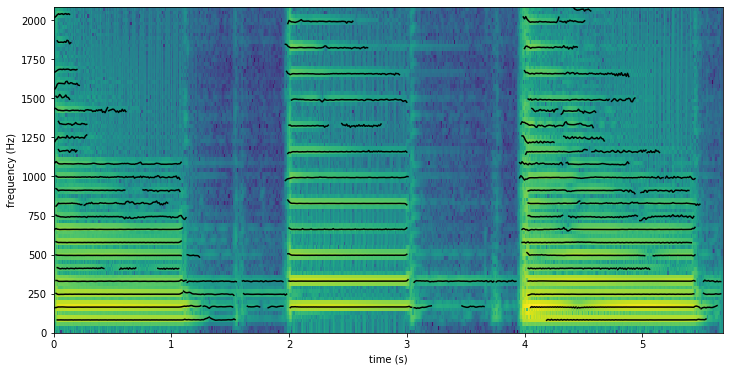

In [34]:
sma.plot_sines(2100)

### Visualization

In [35]:
def plot_sines(mx: np.ndarray,
               tfreq: np.ndarray,
               max_plot_freq: int,
               n_fft: int,
               n_hop: int,
               sample_rate: int,
               figsize=(12, 6)):
    n_bins = int(n_fft*max_plot_freq/sample_rate) + 1
    n_frames = mx.shape[0]
    
    frame_times = np.arange(n_frames) / sample_rate * n_hop
    bin_freqs = np.arange(n_bins) * sample_rate / n_fft
    
    tracks = tfreq * np.less(tfreq, max_plot_freq)
    tracks[tracks <= 0] = np.nan
    
    plt.figure(figsize=figsize)
    plt.pcolormesh(frame_times, bin_freqs, mx.T[:n_bins])
    plt.plot(frame_times, tracks, c='k', lw=1.5)
    plt.tight_layout()
    plt.show()

### Validation

In [36]:
path = "../../sms-tools/sounds/flute-A4.wav"

In [37]:
x, sr = load_audio(path)

In [38]:
n_fft = 1024
n_hop = 150
n_window = 601
window_name = 'blackman'

In [39]:
window = get_cola_window(window_name, n_window, n_hop)

In [40]:
window.sum()

150.0

In [41]:
peak_thresh = -80
min_sine_duration = 0.1
max_n_sines = 150
max_plot_freq = 5000
freq_dev_offset = 20
freq_dev_slope = 0.01

In [42]:
spectrum = list(stft(x, n_fft, n_hop, window))
mx, px = (np.stack(s) for s in zip(*spectrum))

In [43]:
freqs = sine_model_analysis(x, sr, window, n_fft, n_hop, 
                            peak_thresh,
                            max_n_sines=max_n_sines,
                            min_sine_duration=min_sine_duration,
                            freq_dev_offset=freq_dev_offset,
                            freq_dev_slope=freq_dev_slope)

In [44]:
freqs.shape

(636, 150)

In [45]:
Peak?

Init signature: Peak(frequency: float, magnitude: float, phase: float)
Docstring:      <no docstring>
Type:           type
Subclasses:     


In [46]:
mx.shape

(636, 513)

In [47]:
ft = freqs.T[0]

In [48]:
ftracks = []
for ft in freqs.T:
    track_start = None
    for i, n in enumerate(ft):
        if n == 0:
            if track_start is not None:
                peaks = [Peak(f, 0, 0) for f in ft[track_start:i]]
                track = SineTrack(peaks, track_start, i)
                ftracks.append(track)
                track_start = None
        else:
            if track_start is None:
                track_start = i

In [49]:
ftracks[:5]

[SineTrack(freq=453.1330094577483, start=1, end=634, len=633),
 SineTrack(freq=3540.536347159761, start=21, end=543, len=522),
 SineTrack(freq=3963.8833424957184, start=40, end=87, len=47),
 SineTrack(freq=1758.9033656276242, start=175, end=329, len=154),
 SineTrack(freq=1786.5916735653934, start=330, end=581, len=251)]

In [50]:
len(ftracks)

47

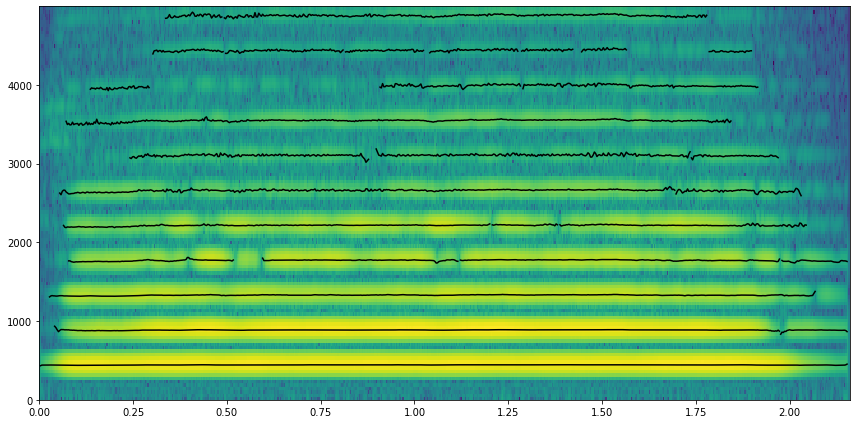

In [51]:
plot_sines(mx, freqs, max_plot_freq, n_fft, n_hop, sr)

In [52]:
signal = Signal(path)
sma = SineModelAnalysis(signal, 
                        fft_size=n_fft,
                        window_name=window_name,
                        frame_size=n_window,
                        hop_size=n_hop,
                        peak_threshold=peak_thresh,
                        freq_dev_offset=freq_dev_offset,
                        freq_dev_slope=freq_dev_slope,
                        min_track_duration=min_sine_duration)

In [53]:
sma_frames = list(sma.sine_model_frames)

In [54]:
len(sma.all_tracks), len(sma.tracks)

(1599, 47)

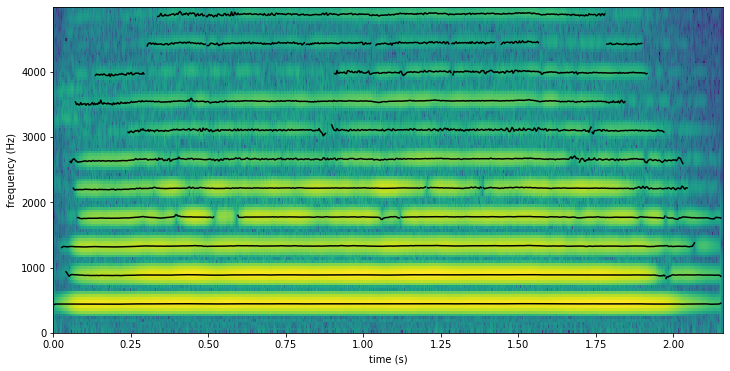

In [55]:
sma.plot_sines(5000)

In [56]:
sorted(sma.tracks, key=lambda t: (t.start_index, t.end_index))[:10]

[SineTrack(freq=453.1330094577483, start=1, end=634, len=633),
 SineTrack(freq=1376.7033411035488, start=8, end=609, len=601),
 SineTrack(freq=871.5070270428729, start=12, end=581, len=569),
 SineTrack(freq=2661.173228248124, start=16, end=499, len=483),
 SineTrack(freq=2233.9888494561847, start=19, end=354, len=335),
 SineTrack(freq=3540.536347159761, start=21, end=543, len=522),
 SineTrack(freq=1775.1437638712453, start=23, end=153, len=130),
 SineTrack(freq=3963.8833424957184, start=40, end=87, len=47),
 SineTrack(freq=3054.1296134451545, start=71, end=259, len=188),
 SineTrack(freq=5734.602323347236, start=84, end=185, len=101)]

In [57]:
sorted(ftracks, key=lambda t: (t.start_index, t.end_index))[:10]

[SineTrack(freq=453.1330094577483, start=1, end=634, len=633),
 SineTrack(freq=1376.7033411035488, start=8, end=609, len=601),
 SineTrack(freq=871.5070270428729, start=12, end=581, len=569),
 SineTrack(freq=2661.173228248124, start=16, end=499, len=483),
 SineTrack(freq=2233.9888494561847, start=19, end=354, len=335),
 SineTrack(freq=3540.536347159761, start=21, end=543, len=522),
 SineTrack(freq=1775.1437638712453, start=23, end=153, len=130),
 SineTrack(freq=3963.8833424957184, start=40, end=87, len=47),
 SineTrack(freq=3054.1296134451545, start=71, end=259, len=188),
 SineTrack(freq=5734.602323347236, start=84, end=185, len=101)]